In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import rcParams
import scipy.stats as stats
from datetime import datetime
import sqlalchemy
%matplotlib inline
sns.set_style('darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 1000)
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

### Permasalahan pada Dataset
- Suatu perusahaan mengurangi harga barang-barang agar dapat terjual lebih banyak namun keuntungan akan berkurang/tidak sesuai dengan ekspektasi
- Apakah rating meningkat setelah perusahaan mengurangi harga jualnya?
- Berapa jumlah kerugian yang dihasilkan setelah mengurangi harga jualnya?
- Kategori produk apa sajakah yang diminati konsumen jika harganya diturunkan?
- Ada 3 category product yang unit terjualnya bernilai dibawah 10% dibandingkan dengan category product yang lain
- Ada 3 category product yang keuntungannya dibawah 150000 dibandingkan dengan category product yang lain
- Dataset banyak null value yang hampir melebihi 50% jika dilakukan drop langsung

### Tujuan Exploratory Data Analysis
- Mencari 3 category yang paling sedikit unit terjual dan paling sedikit menghasilkan keuntungan yang nantinya akan dilakukan promosi untuk membuat orang agar lebih banyak membeli barang dan juga agar dapat meningkatkan keuntungan
- Mencari 3 category dan 3 brand yang paling banyak diminati pembeli berdasarkan gender
- Mencari hubungan shpping_rate, gender, category, keuntungan, mencari hubungan shpping_rate, gender, category, rating, agar dapat dilihat apakah rating berpengaruh terhadap fitur-fitur tersebut
- Membuat rekomendasi produk dan brand yang memiliki potensi dapat meningkat dalam hal unit penjualan dan keuntungan penjualannya

In [2]:
# Membuka file .csv
df = pd.read_csv('ecommerce.csv')

# Menghilangkan kolom Unnamed
df = df.iloc[:, 1:]

# Mengecek 5 baris teratas
df.head()

,category,product,Original_price,price,perc_of_unit_sold,rating,shpping_rate,gender
0,Athletic Shoes,Nike SB Check Solar Cnvs Skateboarding Shoes f...,299.0,211.48,94.0,100.0,FREE Shipping,men
1,Athletic Shoes,Nike Md Runner 2 Two-Tone Textile-Mesh Suede-A...,349.0,289.99,80.0,88.0,FREE Shipping,men
2,Athletic Shoes,"Nike air Heights Sneaker for Women , Size 38 E...",419.0,337.48,77.0,NaN,FREE Shipping,women
3,Athletic Shoes,"Nike Fitness Shoes For Men , 43 EU , Black",319.0,211.48,76.0,80.0,FREE Shipping,men
4,Athletic Shoes,"adidas ASWEERUN Sneaker for Mens, Grey - Size ...",259.0,194.99,94.0,NaN,Eligible for FREE Shipping,men


In [3]:
# Mengecek 5 baris terbawah
df.tail()

,category,product,Original_price,price,perc_of_unit_sold,rating,shpping_rate,gender
604,Watches,JBW Delmare Men's 4 Genuine Diamonds Silicone ...,2624.0,575.99,72.0,92.0,FREE Shipping,men
605,Watches,Michael Kors Lexington Women's White Dial Stai...,762.0,564.98,28.0,76.0,FREE Shipping,women
606,Watches,Puma Casual Watch For Men Analog Stainless Ste...,679.0,262.98,67.0,94.0,FREE Shipping,men
607,Watches,"T5 Watch For Men [Rubber,Chronograph]-H3397G-B",440.0,115.49,40.0,86.0,Eligible for FREE Shipping,men
608,Watches,Tissot Dress Watch For Women Analog Stainless ...,1740.0,960.49,20.0,NaN,FREE Shipping,women


In [4]:
df.columns

Index(['category', 'product', 'Original_price', 'price', 'perc_of_unit_sold',
       'rating', 'shpping_rate', 'gender'],
      dtype='object')

In [6]:
# Mengetahui kolom, null dan data type dari setiap feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   category           609 non-null    object 
 1   product            609 non-null    object 
 2   Original_price     583 non-null    float64
 3   price              609 non-null    float64
 4   perc_of_unit_sold  522 non-null    float64
 5   rating             427 non-null    float64
 6   shpping_rate       567 non-null    object 
 7   gender             581 non-null    object 
dtypes: float64(4), object(4)
memory usage: 38.2+ KB


In [7]:
df.shape

(609, 8)

In [8]:
df.dtypes

category              object
product               object
Original_price       float64
price                float64
perc_of_unit_sold    float64
rating               float64
shpping_rate          object
gender                object
dtype: object

In [9]:
df.index

RangeIndex(start=0, stop=609, step=1)

In [17]:
df.nunique()

category               7
product              602
Original_price       322
price                457
perc_of_unit_sold     92
rating                24
shpping_rate           2
gender                 3
dtype: int64

#### Jumlah Null Value masing-masing Feature

In [22]:
round((df.isnull().sum()/len(df)) * 100, 2)

category              0.00
product               0.00
Original_price        4.27
price                 0.00
perc_of_unit_sold    14.29
rating               29.89
shpping_rate          6.90
gender                4.60
dtype: float64

In [19]:
df.isnull().any()

category             False
product              False
Original_price        True
price                False
perc_of_unit_sold     True
rating                True
shpping_rate          True
gender                True
dtype: bool

- Kolom rating and per_of_unit_sold memiliki persentase null value yang cukup besar
- Selanjutnya, null value akan di drop karena null value tidak akan diikutsertakan dalam analisis

In [24]:
# Sebelum di drop
df.describe()

# NULL VALUE
## Original_price: Mean > Median
## perc_of_unit_sold: Mean < Median
## rating: Mean < Median

,Original_price,price,perc_of_unit_sold,rating
count,583.000000,609.000000,522.000000,427.000000
mean,864.498113,339.434039,57.678161,87.807963
std,1803.365527,285.416406,25.434947,11.422350
min,42.000000,21.400000,2.000000,20.000000
25%,273.000000,140.980000,36.250000,82.000000
50%,499.000000,262.490000,60.000000,88.000000
75%,980.000000,444.990000,79.000000,96.000000
max,29970.000000,3220.000000,99.000000,100.000000


In [25]:
# Mencoba dropna untuk melihat statistik dari setiap kolom
df_temp = df.dropna()
df_temp.describe()

# Original_price: Mean > Median
# price: Mean > Median
# perc_of_unit_sold: Median > Mean
# rating: Mean > Median

,Original_price,price,perc_of_unit_sold,rating
count,351.000000,351.000000,351.000000,351.000000
mean,929.212821,338.657123,62.698006,88.056980
std,1818.035188,274.580470,24.431595,11.019834
min,42.000000,21.400000,2.000000,20.000000
25%,266.000000,125.990000,47.500000,84.000000
50%,560.000000,251.490000,66.000000,90.000000
75%,1026.000000,470.485000,84.000000,96.000000
max,29970.000000,2115.490000,99.000000,100.000000


## Cek Korelasi dataframe sebelum dan setelah drop value

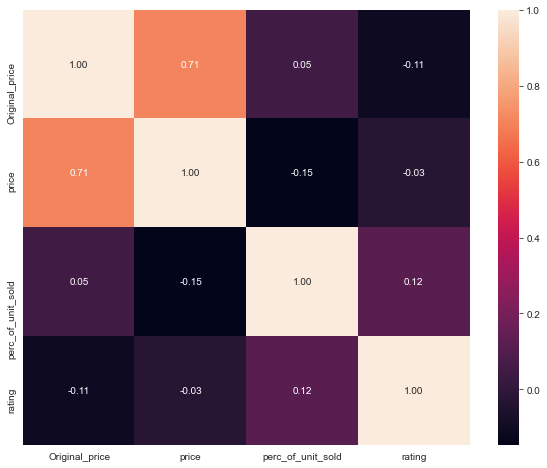

In [26]:
# Cek korelasi jika belum di drop null value
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")

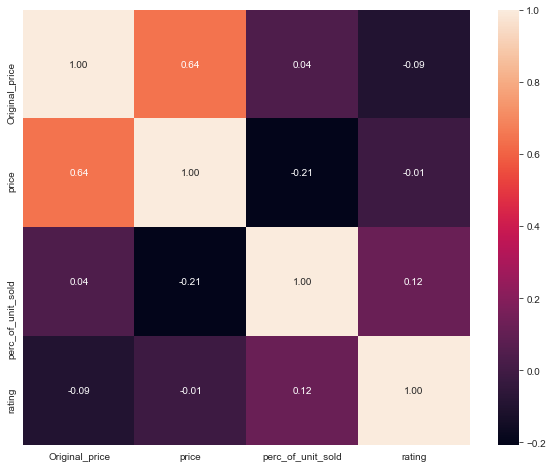

In [27]:
# Cek korelasi setelah di drop null value
plt.figure(figsize=(10, 8))
sns.heatmap(df_temp.corr(), annot=True, fmt=".2f")

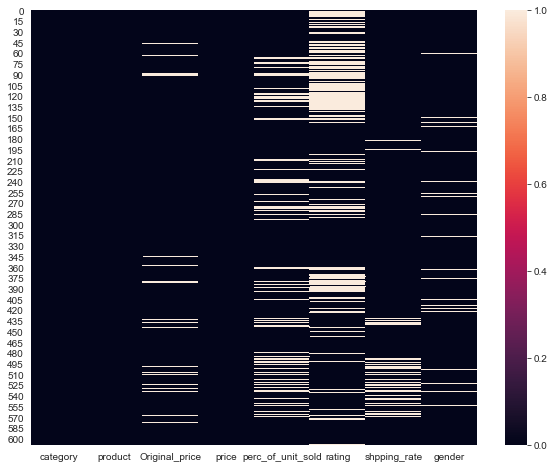

In [28]:
# Null Value dari masing2 feature
plt.figure(figsize=(10, 8))
sns.heatmap(df.isnull())
plt.show()

## Analisis Null Value

In [17]:
total_data_tanpa_drop = df.count()
total_data_tanpa_drop

category             609
product              609
Original_price       583
price                609
perc_of_unit_sold    522
rating               427
shpping_rate         567
gender               581
dtype: int64

In [18]:
total_data_dengan_drop = df.dropna().count()
df_drop_null = df.dropna()
total_data_dengan_drop

category             351
product              351
Original_price       351
price                351
perc_of_unit_sold    351
rating               351
shpping_rate         351
gender               351
dtype: int64

In [19]:
# Ambil data tanpa null value yang paling banyak jumlahnya, yaitu kolom category
print("Jumlah data jika dilakukan drop null value langsung: " + str(round(351/609 *100,2)) + '%')

Jumlah data jika dilakukan drop null value langsung: 57.64%


- Karena setelah di drop datanya menjadi kurang dari setengahnya maka tidak bisa di drop value langsung. 
- Jika di drop, maka akan kehilangan > 50% informasi. 
- Selain itu, korelasi antarfitur menjadi berkurang setelah drop value.
- Oleh karena itu, untuk mengatasi drop value dilakukan imputasi.

## Imputasi Null Value

In [29]:
df.isnull().sum()

category               0
product                0
Original_price        26
price                  0
perc_of_unit_sold     87
rating               182
shpping_rate          42
gender                28
dtype: int64

In [30]:
df.describe()

,Original_price,price,perc_of_unit_sold,rating
count,583.000000,609.000000,522.000000,427.000000
mean,864.498113,339.434039,57.678161,87.807963
std,1803.365527,285.416406,25.434947,11.422350
min,42.000000,21.400000,2.000000,20.000000
25%,273.000000,140.980000,36.250000,82.000000
50%,499.000000,262.490000,60.000000,88.000000
75%,980.000000,444.990000,79.000000,96.000000
max,29970.000000,3220.000000,99.000000,100.000000


In [31]:
# # Original_price: karena Mean > Median, kurva distribusinya berbentuk skewness positive, agar lebih mendekati 
# # nilai Median dan membentuk distribusi normal maka dilakukan pendekatan imputasi dengan strategi .median()
df['Original_price'].fillna(df['Original_price'].median(), inplace=True)

In [32]:
# perc_of_unit_sold: Mean < Median, kurva distribusinya berbentuk skewness negative, agar lebih mendekati 
# nilai Median dan membentuk distribusi normal maka dilakukan pendekatan imputasi dengan strategi .mean()
df['perc_of_unit_sold'].fillna(df['perc_of_unit_sold'].mean(), inplace=True)

In [33]:
# rating: Mean < Median, kurva distribusinya berbentuk skewness negative, agar lebih mendekati 
# nilai Median dan membentuk distribusi normal maka dilakukan pendekatan imputasi dengan strategi .mean()
df['rating'].fillna(df['rating'].mean(), inplace=True)

In [36]:
round(df.isnull().sum()/len(df) * 100, 2)

category             0.0
product              0.0
Original_price       0.0
price                0.0
perc_of_unit_sold    0.0
rating               0.0
shpping_rate         6.9
gender               4.6
dtype: float64

In [37]:
# karena jumlah null value pada shpping_rate dan gender tidak terlalu banyak, yakni 6.9% untuk shpping_rate dan 
# 4.6% untuk gender, maka akan dilakukan dropna untuk
# menghilangkan null value yang terdapat pada shpping_rate dan gender
df.dropna(inplace=True)
df.head()

,category,product,Original_price,price,perc_of_unit_sold,rating,shpping_rate,gender
0,Athletic Shoes,Nike SB Check Solar Cnvs Skateboarding Shoes f...,299.0,211.48,94.0,100.000000,FREE Shipping,men
1,Athletic Shoes,Nike Md Runner 2 Two-Tone Textile-Mesh Suede-A...,349.0,289.99,80.0,88.000000,FREE Shipping,men
2,Athletic Shoes,"Nike air Heights Sneaker for Women , Size 38 E...",419.0,337.48,77.0,87.807963,FREE Shipping,women
3,Athletic Shoes,"Nike Fitness Shoes For Men , 43 EU , Black",319.0,211.48,76.0,80.000000,FREE Shipping,men
4,Athletic Shoes,"adidas ASWEERUN Sneaker for Mens, Grey - Size ...",259.0,194.99,94.0,87.807963,Eligible for FREE Shipping,men


In [38]:
# Jumlah Null Value setelah dilakukan imputasi 
df.isnull().sum()

category             0
product              0
Original_price       0
price                0
perc_of_unit_sold    0
rating               0
shpping_rate         0
gender               0
dtype: int64

## Mencari Unique Value dari masing-masing Feature

In [39]:
df.columns

Index(['category', 'product', 'Original_price', 'price', 'perc_of_unit_sold',
       'rating', 'shpping_rate', 'gender'],
      dtype='object')

In [41]:
# Jumlah unique value dari masing-masing fitur
df.nunique()

category               7
product              535
Original_price       291
price                401
perc_of_unit_sold     93
rating                25
shpping_rate           2
gender                 3
dtype: int64

In [42]:
df['category'].unique()

array(['Athletic Shoes', 'Casual & Dress Shoes', 'Eyewear',
       'Perfumes & Fragrances', 'Sportswear', 'Wallets', 'Watches'],
      dtype=object)

In [44]:
# Karena fitur produk sangat banyak maka unique value tidak akan ditampilkan
# df['product'].unique()

In [45]:
df['Original_price'].unique()

array([  299. ,   349. ,   419. ,   319. ,   259. ,   389. ,   609. ,
         339. ,   359. ,   249. ,   279. ,   499. ,   255. ,   579. ,
         569. ,   352. ,   209. ,   309. ,   289. ,   399. ,   839. ,
         346. ,   709. ,   269. ,   369. ,   629. ,   749. ,   449. ,
         379. ,   489. ,   589. ,   519. ,   469. ,   459. ,   539. ,
         139. ,   479. ,   189. ,   759. ,   329. ,   529. ,   509. ,
         320. ,   639. ,   409. ,   650. ,   750. ,   770. ,  1050. ,
         997. ,   725. ,   250. ,  1329. ,   755. ,  1110. ,   850. ,
         900. ,   201. ,   280. ,   945. ,   614. ,  1014. ,   336. ,
         690. ,  1680. ,   525. ,   820. ,  1286. ,  1039.5,  1040. ,
         870. ,   765. ,   700. ,   547. ,   890. ,  1256. ,   240. ,
         450. ,   910. ,   793. ,  1119. ,   730. ,  1129.8,   950. ,
         780. ,   200. ,  1134. ,   560. ,   658. ,   977. ,  1130. ,
         350. ,  1496. ,   714. ,   390. ,  2000. ,  1000. ,   855. ,
        1490. ,  161

In [46]:
df['price'].unique()

array([ 211.48,  289.99,  337.48,  194.99,  234.99,  233.98,  280.98,
        470.99,  236.99,  225.65,  186.98,  177.99,  175.98,  228.48,
        245.98,  284.49,  191.49,  421.98,  202.99,  274.48,  250.49,
        251.49,  258.98,  342.49,  249.  ,  139.  ,  259.98,  214.99,
        192.99,  629.99,  313.98,  269.  ,  549.49,  308.99,  192.49,
        285.48,  292.98,  270.98,  189.48,  253.98,  409.  ,  419.  ,
        152.48,  144.98,  359.49,  359.98,  213.99,  209.  ,  189.  ,
        199.  ,  169.  ,  159.  ,  386.99,  271.98,  172.99,  295.98,
        268.49,  262.49,  309.98,  100.49,  215.48,   90.49,  553.98,
        545.99,  174.98,  225.98,  222.48,  349.99,  335.49,  298.48,
        187.49,  269.99,  258.49,  280.49,  333.98,  254.49,  238.98,
        341.99,  138.48,  355.98,  203.49,  318.49,  381.99,  325.98,
        286.48,  271.49,  260.99,  270.48,  250.98,  346.98,  351.98,
        427.98,  308.  ,  444.99,  372.49,  157.49,  180.48,  145.98,
        637.49,  238

In [47]:
df['perc_of_unit_sold'].unique()

array([94.        , 80.        , 77.        , 76.        , 30.        ,
       68.        , 71.        , 60.        , 33.        , 69.        ,
       86.        , 87.        , 75.        , 40.        , 50.        ,
       57.        , 61.        , 66.        , 91.        , 42.        ,
       84.        , 92.        , 72.        , 53.        , 57.67816092,
       85.        , 58.        , 90.        , 78.        , 62.        ,
       70.        , 55.        , 81.        , 46.        , 20.        ,
       25.        , 23.        , 14.        , 63.        , 67.        ,
       37.        , 39.        , 15.        , 45.        , 36.        ,
       16.        , 83.        , 88.        , 52.        , 89.        ,
       13.        , 54.        , 29.        ,  2.        , 22.        ,
       19.        , 31.        , 99.        , 73.        , 43.        ,
       65.        , 21.        , 47.        , 32.        , 98.        ,
       56.        , 12.        , 51.        , 17.        , 59.  

In [48]:
df['rating'].unique()

array([100.        ,  88.        ,  87.80796253,  80.        ,
        90.        ,  86.        ,  96.        ,  74.        ,
        92.        ,  66.        ,  78.        ,  60.        ,
        68.        ,  82.        ,  98.        ,  94.        ,
        20.        ,  84.        ,  56.        ,  76.        ,
        40.        ,  70.        ,  62.        ,  72.        ,
        50.        ])

In [49]:
df['shpping_rate'].unique()

array(['FREE Shipping', 'Eligible for FREE Shipping'], dtype=object)

In [50]:
df['gender'].unique()

array(['men', 'women', 'Unisex'], dtype=object)

## Analisis Data

In [51]:
df.head()

,category,product,Original_price,price,perc_of_unit_sold,rating,shpping_rate,gender
0,Athletic Shoes,Nike SB Check Solar Cnvs Skateboarding Shoes f...,299.0,211.48,94.0,100.000000,FREE Shipping,men
1,Athletic Shoes,Nike Md Runner 2 Two-Tone Textile-Mesh Suede-A...,349.0,289.99,80.0,88.000000,FREE Shipping,men
2,Athletic Shoes,"Nike air Heights Sneaker for Women , Size 38 E...",419.0,337.48,77.0,87.807963,FREE Shipping,women
3,Athletic Shoes,"Nike Fitness Shoes For Men , 43 EU , Black",319.0,211.48,76.0,80.000000,FREE Shipping,men
4,Athletic Shoes,"adidas ASWEERUN Sneaker for Mens, Grey - Size ...",259.0,194.99,94.0,87.807963,Eligible for FREE Shipping,men


In [53]:
df.describe()

,Original_price,price,perc_of_unit_sold,rating
count,542.000000,542.000000,542.000000,542.000000
mean,806.872140,330.354815,57.846227,88.031309
std,1488.676764,250.263948,23.834770,9.254845
min,42.000000,21.400000,2.000000,20.000000
25%,282.500000,145.980000,42.000000,86.000000
50%,499.000000,268.745000,57.678161,87.807963
75%,943.250000,442.480000,76.000000,92.000000
max,29970.000000,2115.490000,99.000000,100.000000


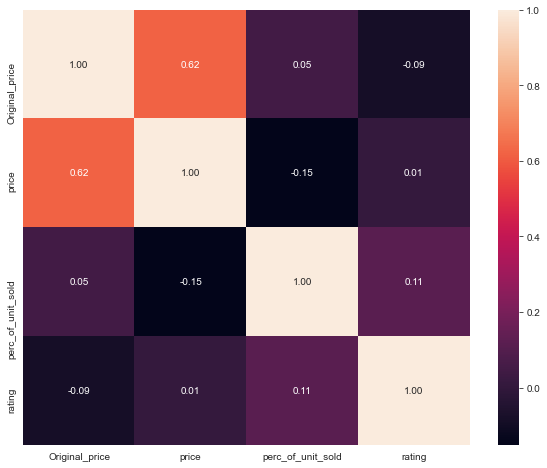

In [52]:
# Cek korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")

### Analisis berdasarkan kategori
- Asumsi:
    - Original_price: Harga sebelum dilakukan diskon (harga seller)
    - price: Harga barang awal (retail)
    - Orig_minus_price: Harga sebelum diskon - price
    - Keuntungan: Orig_minus_price * perc_of_unit_sold


In [54]:
df['Orig_minus_price'] = df['Original_price'] - df['price']
df['Orig_mltply_unit_sold'] = df['Original_price'] * df['perc_of_unit_sold']
df['Price_mltply_unit_sold'] = df['price'] * df['perc_of_unit_sold']
df['Loss'] = df['Orig_mltply_unit_sold'] - df['Price_mltply_unit_sold']
df.head()

,category,product,Original_price,price,perc_of_unit_sold,rating,shpping_rate,gender,Orig_minus_price,Orig_mltply_unit_sold,Price_mltply_unit_sold,Loss
0,Athletic Shoes,Nike SB Check Solar Cnvs Skateboarding Shoes f...,299.0,211.48,94.0,100.000000,FREE Shipping,men,87.52,28106.0,19879.12,8226.88
1,Athletic Shoes,Nike Md Runner 2 Two-Tone Textile-Mesh Suede-A...,349.0,289.99,80.0,88.000000,FREE Shipping,men,59.01,27920.0,23199.20,4720.80
2,Athletic Shoes,"Nike air Heights Sneaker for Women , Size 38 E...",419.0,337.48,77.0,87.807963,FREE Shipping,women,81.52,32263.0,25985.96,6277.04
3,Athletic Shoes,"Nike Fitness Shoes For Men , 43 EU , Black",319.0,211.48,76.0,80.000000,FREE Shipping,men,107.52,24244.0,16072.48,8171.52
4,Athletic Shoes,"adidas ASWEERUN Sneaker for Mens, Grey - Size ...",259.0,194.99,94.0,87.807963,Eligible for FREE Shipping,men,64.01,24346.0,18329.06,6016.94


In [55]:
# Membuat kolom Brand untuk dilakukan analisis Brand
df['Brand'] = df['product'].apply(lambda x: x.capitalize().split()[0])
df.head()

,category,product,Original_price,price,perc_of_unit_sold,rating,shpping_rate,gender,Orig_minus_price,Orig_mltply_unit_sold,Price_mltply_unit_sold,Loss,Brand
0,Athletic Shoes,Nike SB Check Solar Cnvs Skateboarding Shoes f...,299.0,211.48,94.0,100.000000,FREE Shipping,men,87.52,28106.0,19879.12,8226.88,Nike
1,Athletic Shoes,Nike Md Runner 2 Two-Tone Textile-Mesh Suede-A...,349.0,289.99,80.0,88.000000,FREE Shipping,men,59.01,27920.0,23199.20,4720.80,Nike
2,Athletic Shoes,"Nike air Heights Sneaker for Women , Size 38 E...",419.0,337.48,77.0,87.807963,FREE Shipping,women,81.52,32263.0,25985.96,6277.04,Nike
3,Athletic Shoes,"Nike Fitness Shoes For Men , 43 EU , Black",319.0,211.48,76.0,80.000000,FREE Shipping,men,107.52,24244.0,16072.48,8171.52,Nike
4,Athletic Shoes,"adidas ASWEERUN Sneaker for Mens, Grey - Size ...",259.0,194.99,94.0,87.807963,Eligible for FREE Shipping,men,64.01,24346.0,18329.06,6016.94,Adidas


In [56]:
df.describe()

,Original_price,price,perc_of_unit_sold,rating,Orig_minus_price,Orig_mltply_unit_sold,Price_mltply_unit_sold,Loss
count,542.000000,542.000000,542.000000,542.000000,542.000000,5.420000e+02,542.000000,5.420000e+02
mean,806.872140,330.354815,57.846227,88.031309,476.517325,4.845736e+04,18206.692076,3.025066e+04
std,1488.676764,250.263948,23.834770,9.254845,1348.545134,1.375947e+05,17397.175751,1.259670e+05
min,42.000000,21.400000,2.000000,20.000000,-540.490000,6.400000e+02,380.000000,-3.117447e+04
25%,282.500000,145.980000,42.000000,86.000000,108.020000,1.552157e+04,7402.485000,5.504140e+03
50%,499.000000,268.745000,57.678161,87.807963,223.020000,2.599600e+04,14456.612414,1.120609e+04
75%,943.250000,442.480000,76.000000,92.000000,475.520000,4.800450e+04,22742.312500,2.416066e+04
max,29970.000000,2115.490000,99.000000,100.000000,27854.510000,2.937060e+06,207318.020000,2.729742e+06


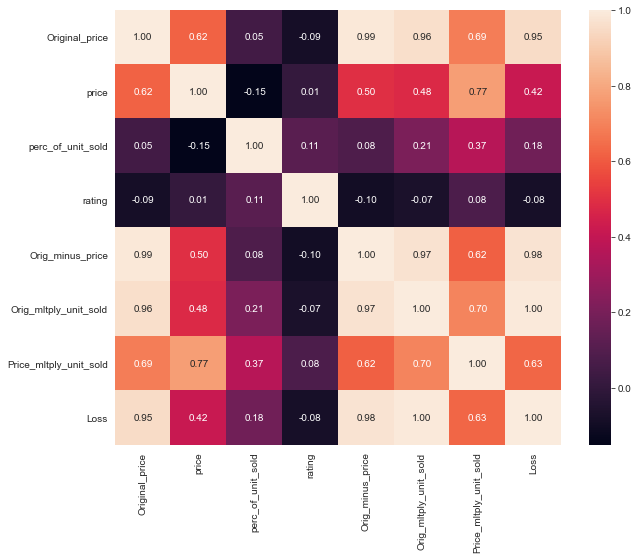

In [57]:
# Cek korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, fmt=".2f")

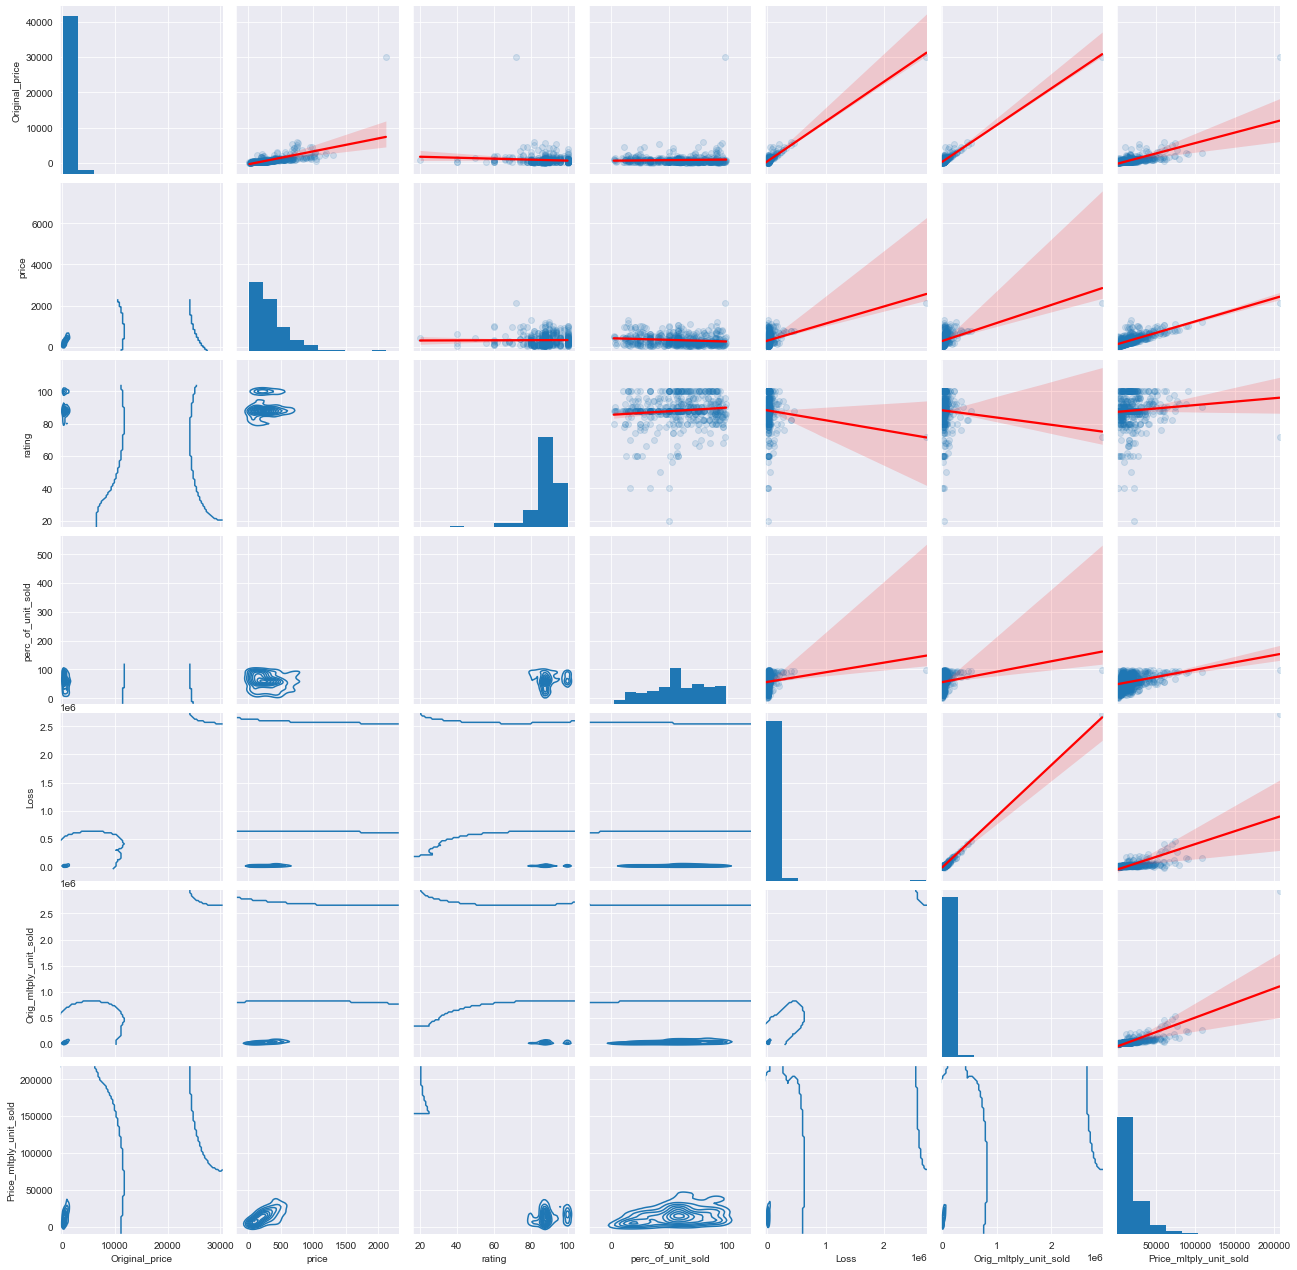

In [64]:
g = sns.PairGrid(df[['Original_price', 'price', 'rating', 'perc_of_unit_sold', 'Loss', 'Orig_mltply_unit_sold', 'Price_mltply_unit_sold']])
g = g.map_upper(sns.regplot, scatter_kws={'alpha':0.15}, line_kws={'color': 'red'})
g = g.map_diag(plt.hist)
g = g.map_lower(sns.kdeplot, colors="C0")

- Semakin banyak unit yang terjual semakin banyak Loss
- Semakin banyak tinggi rating semakin sedikit Loss/semakin untung

### Analisis Unit Terjual terhadap category, gender dan Brand

In [60]:
dt_temp_1 = df.pivot_table(index='category', values='perc_of_unit_sold', aggfunc=['sum', 'count', 'mean', 'median']).sort_values(by=('sum', 'perc_of_unit_sold'), ascending=False).reset_index()
dt_temp_1

,category,sum,count,mean,median
,,perc_of_unit_sold,perc_of_unit_sold,perc_of_unit_sold,perc_of_unit_sold
0,Watches,8509.068966,140,60.779064,61.500000
1,Eyewear,6958.563218,140,49.704023,55.000000
2,Athletic Shoes,5811.816092,93,62.492646,60.000000
3,Perfumes & Fragrances,4616.000000,62,74.451613,77.000000
4,Casual & Dress Shoes,2513.137931,47,53.471020,57.678161
5,Sportswear,1568.390805,30,52.279693,57.678161
6,Wallets,1375.678161,30,45.855939,47.000000


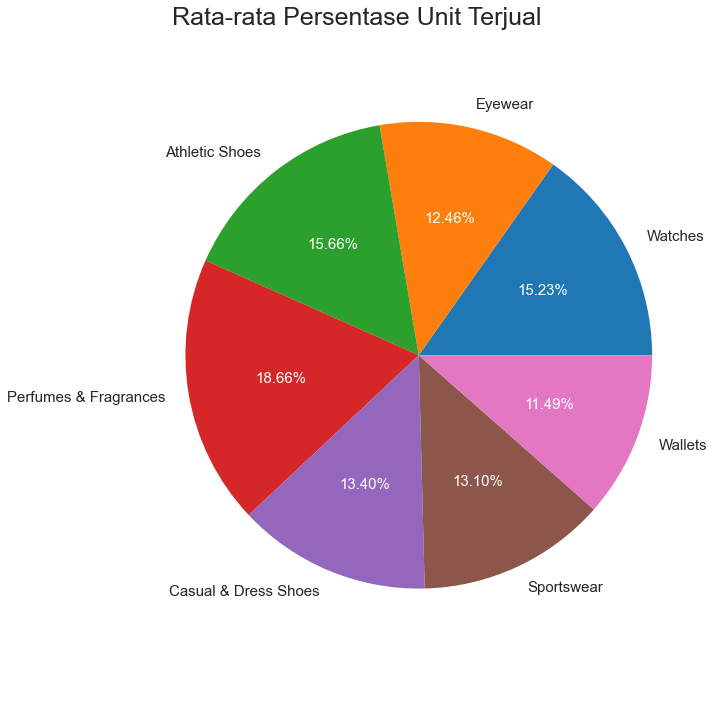

In [66]:
data_perc_of_unit_sold = dt_temp_1[('mean', 'perc_of_unit_sold')]
data_category = dt_temp_1.category

plt.figure(figsize=(10, 10))
_, _, autotexts = plt.pie(data_perc_of_unit_sold , labels=data_category, autopct='%1.2f%%', textprops={'fontsize':15})
for autotext in autotexts:
    autotext.set_color('white')
plt.suptitle('Rata-rata Persentase Unit Terjual', fontsize=25)
plt.rcParams['patch.linewidth'] = 0 
# plt.rcParams['patch.edgecolor'] = 'black' 
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
# plt.savefig('1_.png')
plt.show()

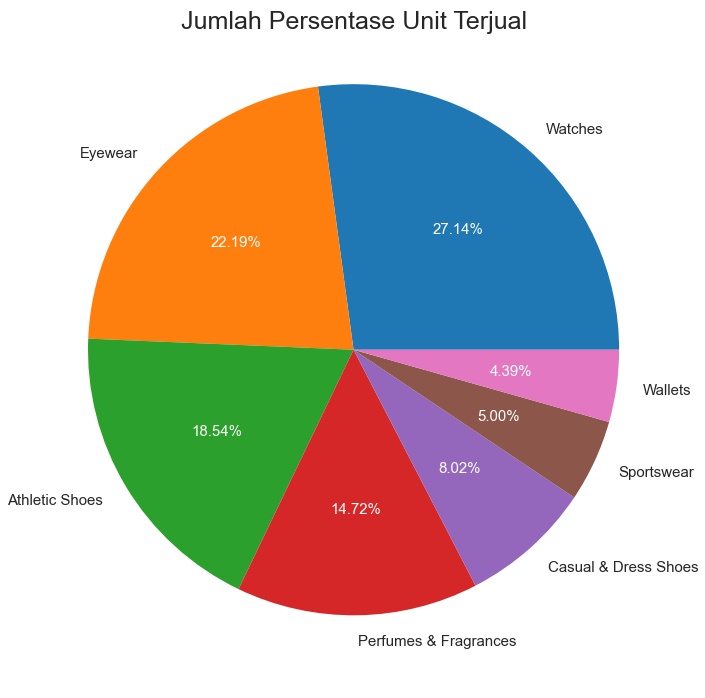

In [67]:
data_perc_of_unit_sold = dt_temp_1[('sum', 'perc_of_unit_sold')]
data_category = dt_temp_1.category

plt.figure(figsize=(10, 10))
_, _, autotexts = plt.pie(data_perc_of_unit_sold , labels=data_category, autopct='%1.2f%%', textprops={'fontsize':15})
for autotext in autotexts:
    autotext.set_color('white')
plt.suptitle('Jumlah Persentase Unit Terjual', fontsize=25)
plt.rcParams['patch.linewidth'] = 0 
# plt.rcParams['patch.edgecolor'] = 'black' 
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
# plt.savefig('1_.png')
plt.show()

### Category Insight
1. Jumlah Unit Terjual
    - Category yang memiliki persentase unit terjual paling banyak adalah category: Watches, Eyewear dan Athletic Shoes
    - Category yang memiliki persentase unit terjual paling sedikit adalah category: Perfumes & Fragrances, Casual & Dress Shoes, Sportswear, Wallets
2. Rata-rata Unit Terjual
    - Category yang memiliki persentase unit terjual paling banyak adalah category: Perfumes & Fragrances, Athletic Shoes and Watches
    - Category yang memiliki persentase unit terjual paling sedikit adalah category: Wallets, Eyewear, Sportswear, dan Casual & Dress Shoes

Karena perusahaan bertujuan untuk meningkatkan unit jual dari kategori barang yang memiliki persentase terendah, maka selanjutnya hanya akan dipilih kategori Casual & Dress Shoes, Sportswear, Wallets.

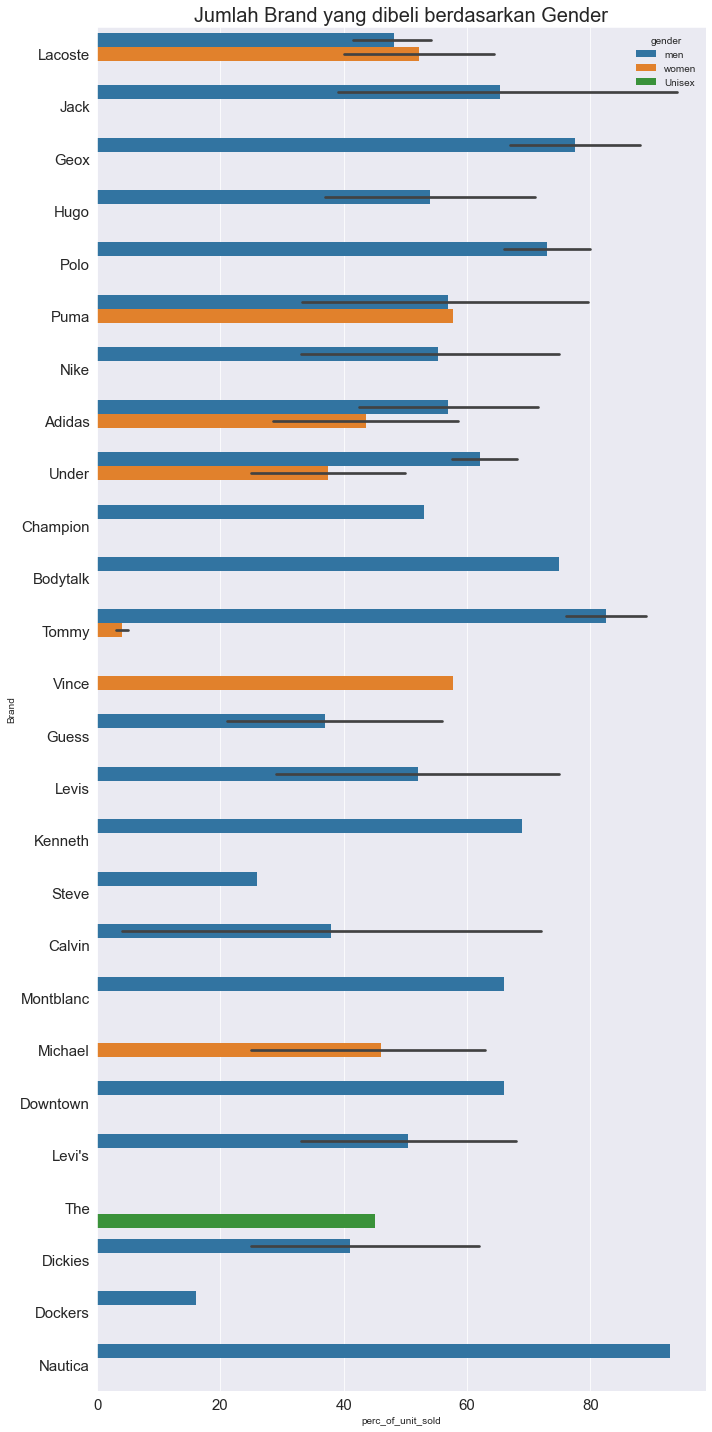

In [70]:
# Mengambil 3 category yang unit terjualnya paling rendah
dt_temp_2 = df[(df['category'] == 'Wallets') | (df['category'] == 'Sportswear') | (df['category'] == 'Casual & Dress Shoes')]
# dt_temp_2.pivot_table(index=['category', 'Brand'], values='gender', aggfunc='count')
# dt_temp_2 
plt.figure(figsize=(10, 20))

# Analisa Brand vs Gender vs Unit of Sold
ax = sns.barplot(x="perc_of_unit_sold", y="Brand", hue="gender",
                 data=dt_temp_2)
plt.title('Jumlah Brand yang dibeli berdasarkan Gender', fontsize=20)
plt.tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig('2_.png')

In [89]:
dt_temp_2.pivot_table(index=['category', 'Brand'], columns='gender', values='perc_of_unit_sold', aggfunc='mean')

gender                          Unisex        men      women
category             Brand                                  
Casual & Dress Shoes Geox          NaN  77.500000        NaN
                     Hugo          NaN  54.000000        NaN
                     Jack          NaN  65.333333        NaN
                     Lacoste       NaN  48.169540  52.169540
                     Nike          NaN  33.000000        NaN
                     Polo          NaN  73.000000        NaN
                     Puma          NaN  67.452107  57.678161
Sportswear           Adidas        NaN  56.946360  43.600000
                     Bodytalk      NaN  75.000000        NaN
                     Champion      NaN  53.000000        NaN
                     Nike          NaN  66.339080        NaN
                     Puma          NaN  25.000000  57.678161
                     Under         NaN  62.059387  37.500000
Wallets              Calvin        NaN  38.000000        NaN
                     Dickies       NaN  41.000000        NaN
                     Dockers       NaN  16.000000        NaN
                     Downtown      NaN  66.000000        NaN
                     Guess         NaN  37.000000        NaN
                     Kenneth       NaN  69.000000        NaN
                     Levi's        NaN  50.500000        NaN
                     Levis         NaN  52.000000        NaN
                     Michael       NaN        NaN  46.000000
                     Montblanc     NaN  66.000000        NaN
                     Nautica       NaN  93.000000        NaN
                     Steve         NaN  26.000000        NaN
                     The          45.0        NaN        NaN
                     Tommy         NaN  82.500000   4.000000
                     Vince         NaN        NaN  57.678161

### Brand of 3 Categories Insight
Dengan Category Wallets, Sportswear dan Casual & Dress Shoes, potensi Brand yang masih banyak dibeli pada:
1. Casual & Dress Shoes:
    - Pria:
        - Unit terjual tertinggi ada pada Brand: Geox, Polo dan Puma
    - Wanita:
        - Unit terjual tertinggi ada pada Brand: Lacoste dan Puma
2. Sportswear:
    - Pria:
        - Unit terjual tertinggi ada pada Brand: Bodytalk, Nike dan Under
    - Wanita:
        - Unit terjual tertinggi ada pada Brand: Puma, Adidas dan Under
3. Wallets:
    - Pria:
        - Unit terjual tertinggi ada pada Brand: Nautica, Tommy, dan Kenneth
    - Wanita:
        - Unit terjual tertinggi ada pada Brand: Vince dan Michael
    - Unisex:
        - Unit terjual tertinggi ada pada Brand: The

### Analisis Loss terhadap Category, Gender dan Brand

In [81]:
dt_temp_3 = df.pivot_table(index='category', values='Loss', aggfunc=['sum', 'count', 'mean', 'median'])
dt_temp_3[('sum', 'Loss')].sort_values(ascending=False)

category
Watches                  1.115438e+07
Eyewear                  2.890442e+06
Perfumes & Fragrances    8.473583e+05
Athletic Shoes           7.703668e+05
Casual & Dress Shoes     4.231424e+05
Wallets                  1.663315e+05
Sportswear               1.438387e+05
Name: (sum, Loss), dtype: float64

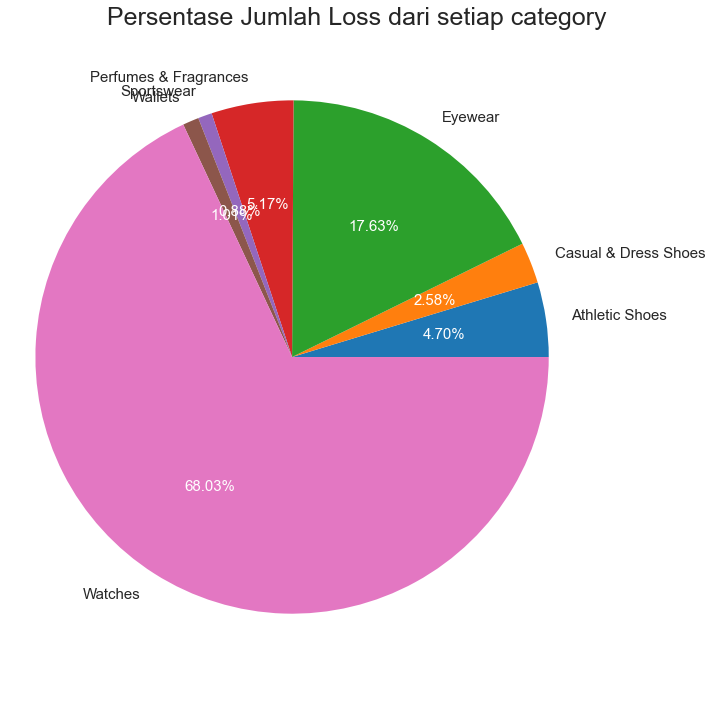

In [86]:
data_loss = dt_temp_3[('sum', 'Loss')]
data_category = dt_temp_3.index

plt.figure(figsize=(10, 10))
_, _, autotexts = plt.pie(data_loss  , labels=data_category, autopct='%1.2f%%', textprops={'fontsize':15})
for autotext in autotexts:
    autotext.set_color('white')
plt.suptitle('Persentase Jumlah Loss dari setiap category', fontsize=25)
plt.rcParams['patch.linewidth'] = 0 
# plt.rcParams['patch.edgecolor'] = 'black' 
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
# plt.savefig('3_.png')
plt.show()

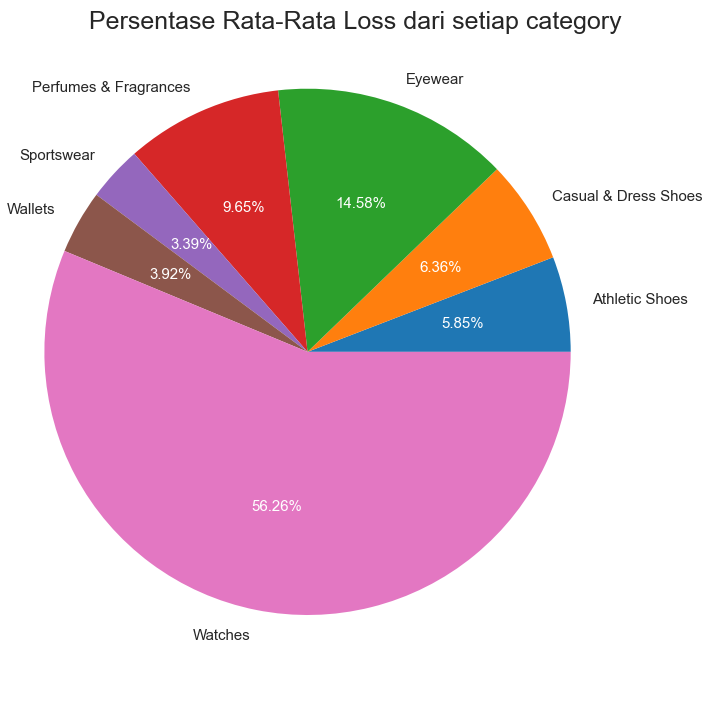

In [87]:
data_loss_1 = dt_temp_3[('mean', 'Loss')]
data_category = dt_temp_3.index

plt.figure(figsize=(10, 10))
_, _, autotexts = plt.pie(data_loss_1, labels=data_category, autopct='%1.2f%%', textprops={'fontsize':15})
for autotext in autotexts:
    autotext.set_color('white')
plt.suptitle('Persentase Rata-Rata Loss dari setiap category', fontsize=25)
plt.rcParams['patch.linewidth'] = 0 
# plt.rcParams['patch.edgecolor'] = 'black' 
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
# plt.savefig('3_.png')
plt.show()

### Category Insight:
1. Jumlah Loss
    - Loss tertinggi ada pada kategori: Watches, Eyewear dan Perfumes & Fragrances
    - Loss terendah ada pada kategori: Sportswear, Wallets dan Causal & Dress Shoes, Athletic Shoes
2. Rata-rata Loss
    - Loss tertinggi ada pada kategori: Watches, Eyewear dan Perfumes & Fragrances
    - Loss terendah ada pada kategori: Sportswear, Wallets dan Causal & Dress Shoes, Athletic Shoes

Karena seller ingin meningkatkan keuntungan pada kategori yang memiliki keuntungan terendah, maka akan dipilih kategori Wallets, Sportswear dan Casual & Dress Shoes.

In [90]:
df.head()

,category,product,Original_price,price,perc_of_unit_sold,rating,shpping_rate,gender,Orig_minus_price,Orig_mltply_unit_sold,Price_mltply_unit_sold,Loss,Brand
0,Athletic Shoes,Nike SB Check Solar Cnvs Skateboarding Shoes f...,299.0,211.48,94.0,100.000000,FREE Shipping,men,87.52,28106.0,19879.12,8226.88,Nike
1,Athletic Shoes,Nike Md Runner 2 Two-Tone Textile-Mesh Suede-A...,349.0,289.99,80.0,88.000000,FREE Shipping,men,59.01,27920.0,23199.20,4720.80,Nike
2,Athletic Shoes,"Nike air Heights Sneaker for Women , Size 38 E...",419.0,337.48,77.0,87.807963,FREE Shipping,women,81.52,32263.0,25985.96,6277.04,Nike
3,Athletic Shoes,"Nike Fitness Shoes For Men , 43 EU , Black",319.0,211.48,76.0,80.000000,FREE Shipping,men,107.52,24244.0,16072.48,8171.52,Nike
4,Athletic Shoes,"adidas ASWEERUN Sneaker for Mens, Grey - Size ...",259.0,194.99,94.0,87.807963,Eligible for FREE Shipping,men,64.01,24346.0,18329.06,6016.94,Adidas


In [93]:
loss_data = df.pivot_table(index='category', values=['Loss', 'perc_of_unit_sold', 'rating'], aggfunc=['sum', 'mean']).reset_index()
loss_data

category           sum                                  \
                                  Loss perc_of_unit_sold        rating   
0         Athletic Shoes  7.703668e+05       5811.816092   8461.822014   
1   Casual & Dress Shoes  4.231424e+05       2513.137931   4186.702576   
2                Eyewear  2.890442e+06       6958.563218  12117.470726   
3  Perfumes & Fragrances  8.473583e+05       4616.000000   5304.000000   
4             Sportswear  1.438387e+05       1568.390805   2667.967213   
5                Wallets  1.663315e+05       1375.678161   2696.079625   
6                Watches  1.115438e+07       8509.068966  12278.927400   

           mean                               
           Loss perc_of_unit_sold     rating  
0   8283.514504         62.492646  90.987333  
1   9003.030152         53.471020  89.078778  
2  20646.014831         49.704023  86.553362  
3  13667.068871         74.451613  85.548387  
4   4794.624042         52.279693  88.932240  
5   5544.383851         45.855939  89.869321  
6  79674.142462         60.779064  87.706624

In [149]:
sum_loss_data = loss_data[['category', 'sum']]
mean_loss_data = loss_data[['category', 'mean']]
sum_loss_data

category           sum                                
                                  Loss perc_of_unit_sold        rating
0         Athletic Shoes  7.703668e+05       5811.816092   8461.822014
1   Casual & Dress Shoes  4.231424e+05       2513.137931   4186.702576
2                Eyewear  2.890442e+06       6958.563218  12117.470726
3  Perfumes & Fragrances  8.473583e+05       4616.000000   5304.000000
4             Sportswear  1.438387e+05       1568.390805   2667.967213
5                Wallets  1.663315e+05       1375.678161   2696.079625
6                Watches  1.115438e+07       8509.068966  12278.927400

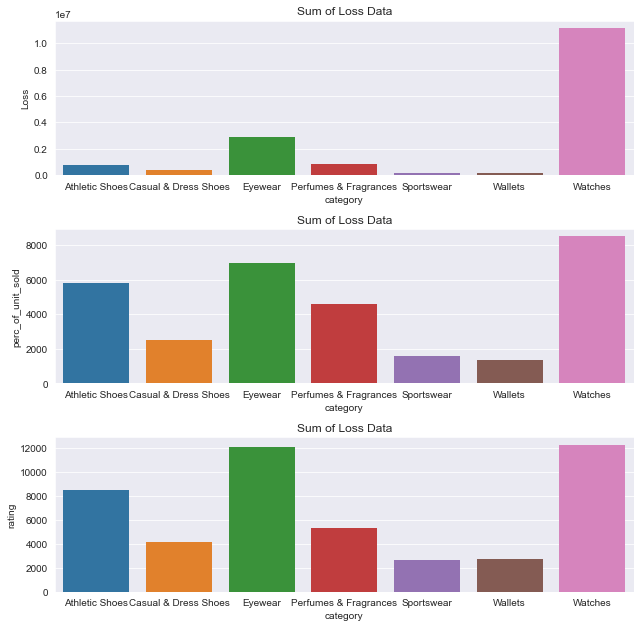

In [148]:
fig = plt.figure(figsize=(9, 20))
cols = sum_loss_data.columns

for i in range(1, len(sum_loss_data.columns)):
    ax = fig.add_subplot(7, 1, i)
    plt.title('Sum of Loss Data')
    sns.barplot(x='category', y=cols[i], data=sum_loss_data)
    plt.ylabel(cols[i][1])

plt.tight_layout()

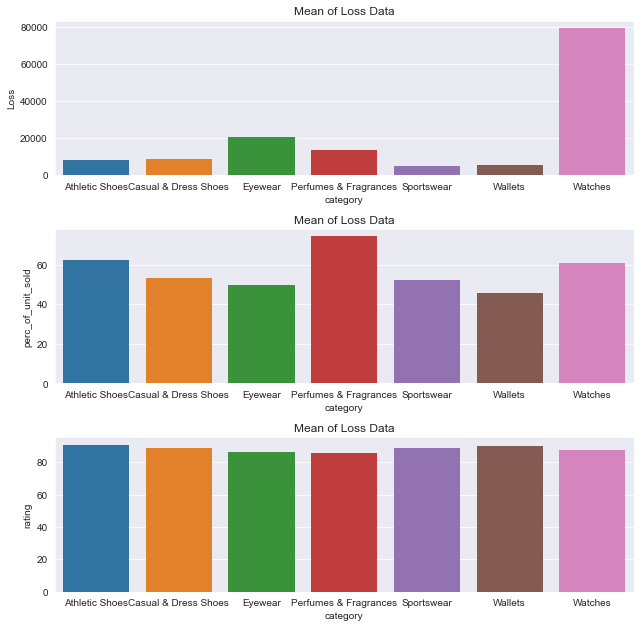

In [150]:
fig = plt.figure(figsize=(9, 20))
cols = mean_loss_data.columns

for i in range(1, len(mean_loss_data.columns)):
    ax = fig.add_subplot(7, 1, i)
    plt.title('Mean of Loss Data')
    sns.barplot(x='category', y=cols[i], data=mean_loss_data)
    plt.ylabel(cols[i][1])

plt.tight_layout()

In [108]:
new_df = pd.DataFrame(df.groupby(['Brand', 'category']).agg({'product': 'count', 'perc_of_unit_sold': 'mean', 'Loss': 'mean'})).reset_index()
new_df

,Brand,category,product,perc_of_unit_sold,Loss
0,Adidas,Athletic Shoes,16,73.625000,8587.869375
1,Adidas,Sportswear,16,48.604885,5288.972205
2,Akribos,Watches,10,74.000000,118584.384000
3,Alexander,Eyewear,1,57.678161,40548.900690
4,Arnette,Eyewear,4,44.839080,8808.241609
5,Asics,Athletic Shoes,22,51.882968,11298.799498
6,August,Watches,5,81.600000,80947.252000
7,Bebe,Perfumes & Fragrances,1,75.000000,7163.250000
8,Bentley,Perfumes & Fragrances,1,92.000000,18770.760000
9,Body,Perfumes & Fragrances,1,74.000000,9910.820000


In [109]:
new_df['Loss_per_unit_sold'] = new_df['Loss']/new_df['perc_of_unit_sold']

In [114]:
new_df.sort_values(by='Loss_per_unit_sold', ascending=False, inplace=True)

In [115]:
new_df

,Brand,category,product,perc_of_unit_sold,Loss,Loss_per_unit_sold
64,Jbw,Watches,20,64.750000,328702.630500,5076.488502
16,Burgi,Watches,1,70.000000,128836.400000,1840.520000
2,Akribos,Watches,10,74.000000,118584.384000,1602.491676
15,Burberry,Watches,11,71.727273,91866.280909,1280.771977
80,Miu,Eyewear,1,50.000000,51151.000000,1023.020000
103,Salvatore,Eyewear,1,57.678161,58342.036552,1011.510000
6,August,Watches,5,81.600000,80947.252000,992.000637
11,Bottega,Eyewear,1,14.000000,12852.140000,918.010000
113,Tissot,Watches,5,21.200000,17192.612000,810.972264
47,Fendi,Eyewear,1,40.000000,31060.400000,776.510000


In [152]:
new_df.pivot_table(index='category', values='Loss_per_unit_sold', aggfunc='mean').sort_values(by='Loss_per_unit_sold', ascending=False)

,Loss_per_unit_sold
category,
Watches,784.590366
Eyewear,498.997458
Perfumes & Fragrances,170.637182
Casual & Dress Shoes,167.086128
Wallets,123.839864
Athletic Shoes,119.324359
Sportswear,83.540294


- Category Product yang paling banyak menghasilkan Loss/kerugian adalah Watches, Eyewear dan Perfumes & Fragrances.
- Jika unit terjualnya dibandingkan, Watches dan Perfumes & Fragrances menghasilkan banyak unit yang terjual. Namun, untuk Eyewear, jumlah rata-rata produk yang terjualnya terbilang lebih rendah dibanding Athletic Shoes.
- Hal ini berarti, produk category Eyewear tidak terlalu diminati sehingga walaupun harganya diturunkan, minat pembelian tidak terlalu naik drastis.
- Jika harga diturunkan kembali, kerugian akan semakin meningkat. Oleh karena itu, hal yang perlu dilakukan adalah perumusan atau marketing untuk produk category Eyewear lebih digencarkan agar lebih diminati konsumen.

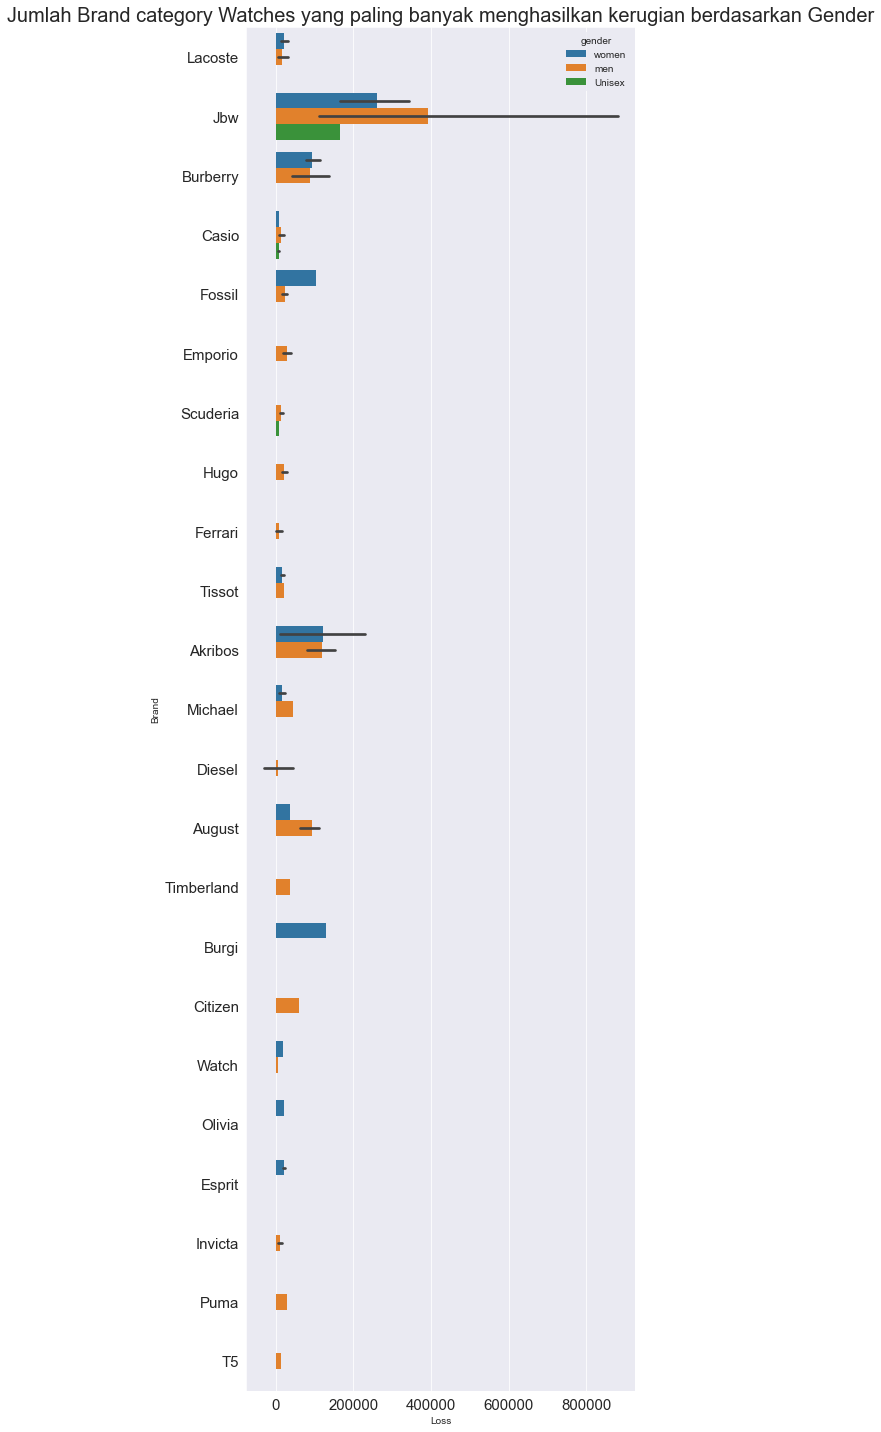

In [156]:
# dt_temp_4 = df[(df['category'] == 'Watches') | (df['category'] == 'Eyewear') | (df['category'] == 'Perfumes & Fragrances')]
dt_temp_4 = df[(df['category'] == 'Watches')]
# dt_temp_2.pivot_table(index=['category', 'Brand'], values='gender', aggfunc='count')
dt_temp_4 
plt.figure(figsize=(10, 20))
# ax = sns.countplot(y="Brand", hue='gender', data=dt_temp_4)
ax = sns.barplot(x="Loss", y="Brand", hue="gender",
                 data=dt_temp_4)
plt.title('Jumlah Brand category Watches yang paling banyak menghasilkan kerugian berdasarkan Gender', fontsize=20)
plt.tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig('4_.png')

- Untuk category Watches, jumlah kerugian terbanyak ada pada Brand Jbw, Burgi, Akribos, Burberry dan August.
- Sehingga, jika harga category Watches diturunkan, konsumen paling banyak membeli pada kelima brand tersebut.

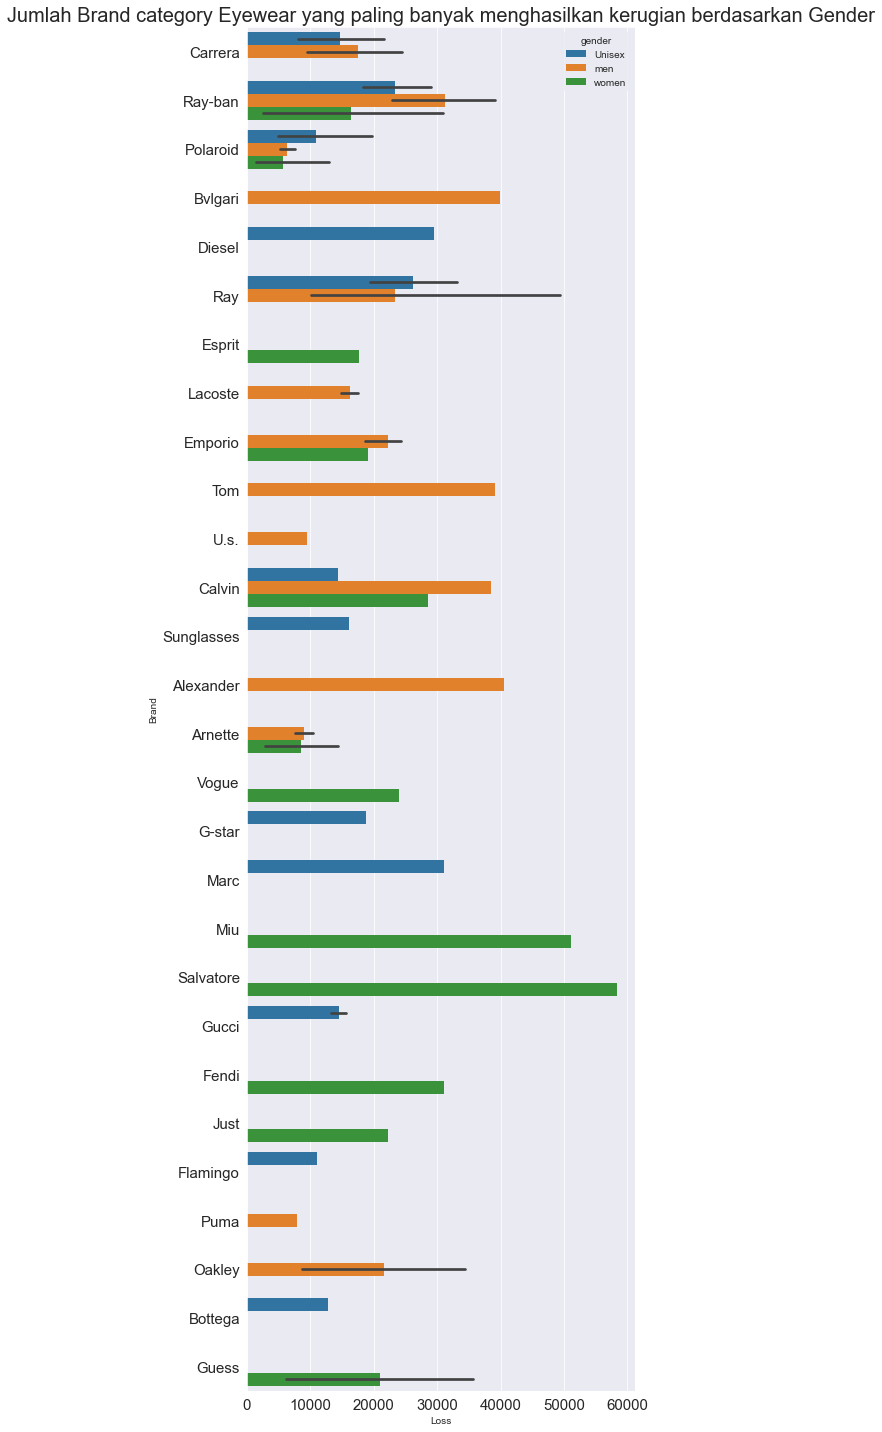

In [157]:
# dt_temp_4 = df[(df['category'] == 'Watches') | (df['category'] == 'Eyewear') | (df['category'] == 'Perfumes & Fragrances')]
dt_temp_5 = df[(df['category'] == 'Eyewear')]
# dt_temp_2.pivot_table(index=['category', 'Brand'], values='gender', aggfunc='count')
dt_temp_5 
plt.figure(figsize=(10, 20))
# ax = sns.countplot(y="Brand", hue='gender', data=dt_temp_4)
ax = sns.barplot(x="Loss", y="Brand", hue="gender",
                 data=dt_temp_5)
plt.title('Jumlah Brand category Eyewear yang paling banyak menghasilkan kerugian berdasarkan Gender', fontsize=20)
plt.tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig('4_.png')

- Untuk category Eyewear, jumlah kerugian terbanyak ada pada Brand Miu, Salvatore, Bottega, Fendi dan G-Star.
- Sehingga, jika harga category Eyewear diturunkan, konsumen paling banyak membeli pada kelima brand tersebut.

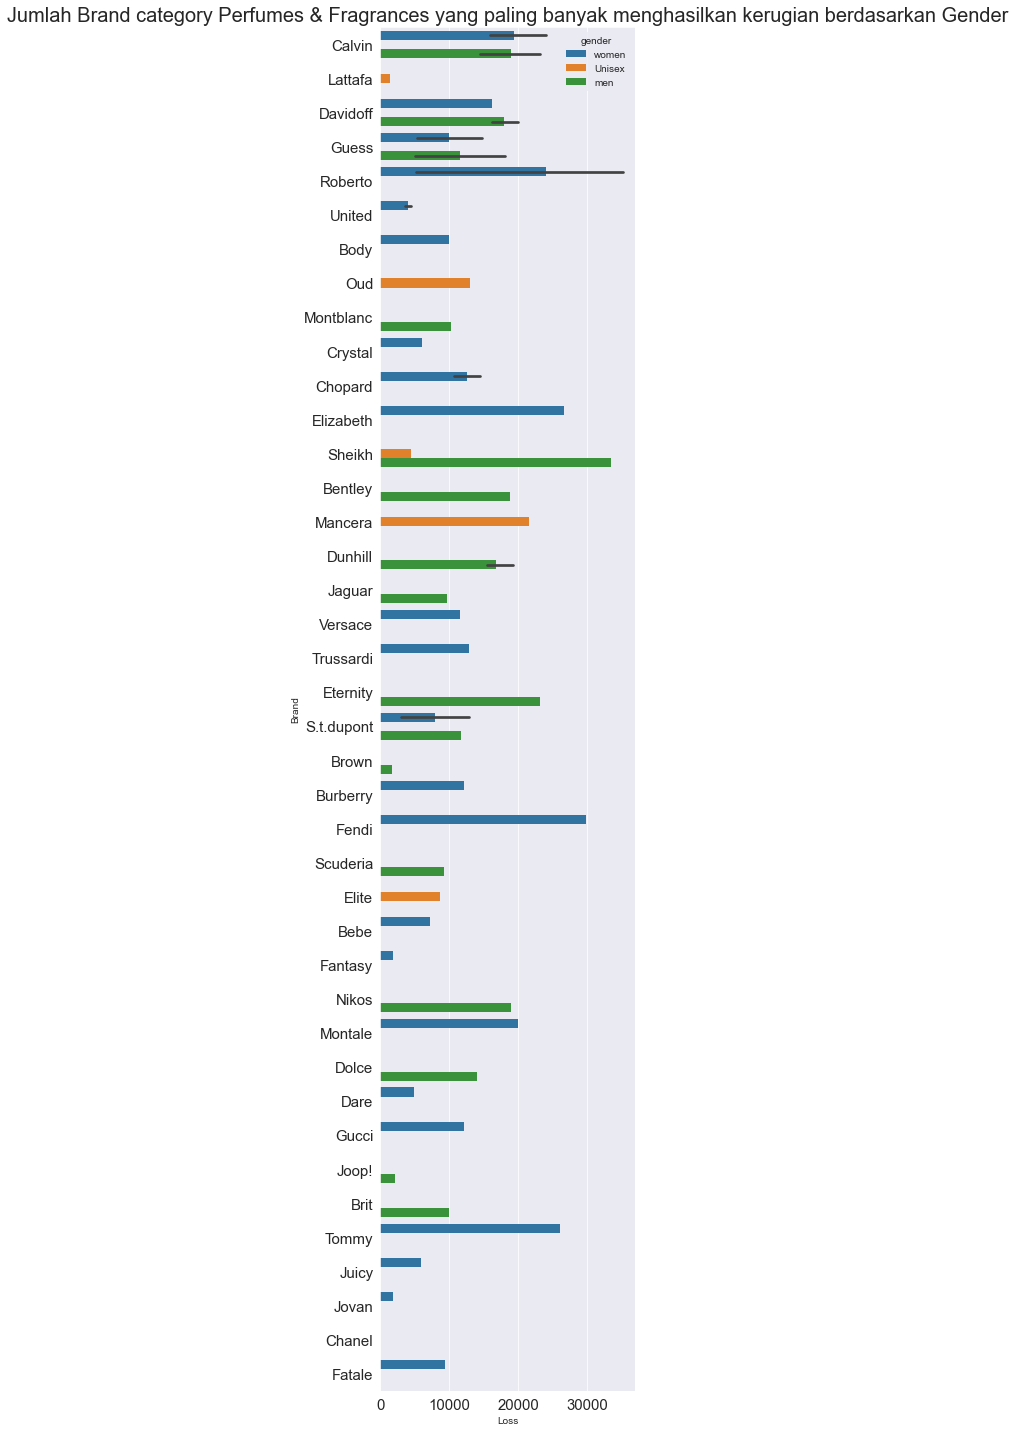

In [158]:
# dt_temp_4 = df[(df['category'] == 'Watches') | (df['category'] == 'Eyewear') | (df['category'] == 'Perfumes & Fragrances')]
dt_temp_6 = df[(df['category'] == 'Perfumes & Fragrances')]
# dt_temp_2.pivot_table(index=['category', 'Brand'], values='gender', aggfunc='count')
dt_temp_6 
plt.figure(figsize=(10, 20))
# ax = sns.countplot(y="Brand", hue='gender', data=dt_temp_4)
ax = sns.barplot(x="Loss", y="Brand", hue="gender",
                 data=dt_temp_6)
plt.title('Jumlah Brand category Perfumes & Fragrances yang paling banyak menghasilkan kerugian berdasarkan Gender', fontsize=20)
plt.tick_params(labelsize=15)
plt.tight_layout()
# plt.savefig('4_.png')

- Untuk category Perfumes & Fragrances, jumlah kerugian terbanyak ada pada Brand Fatale, Roberto, Fendi, Tommy, Elizabeth dan Brit.
- Sehingga, jika harga category Perfumes & Fragrances diturunkan, konsumen paling banyak membeli pada brand-brand tersebut.

### Mencari hubungan Rating VS Unit Terjual

<Figure size 720x576 with 0 Axes>

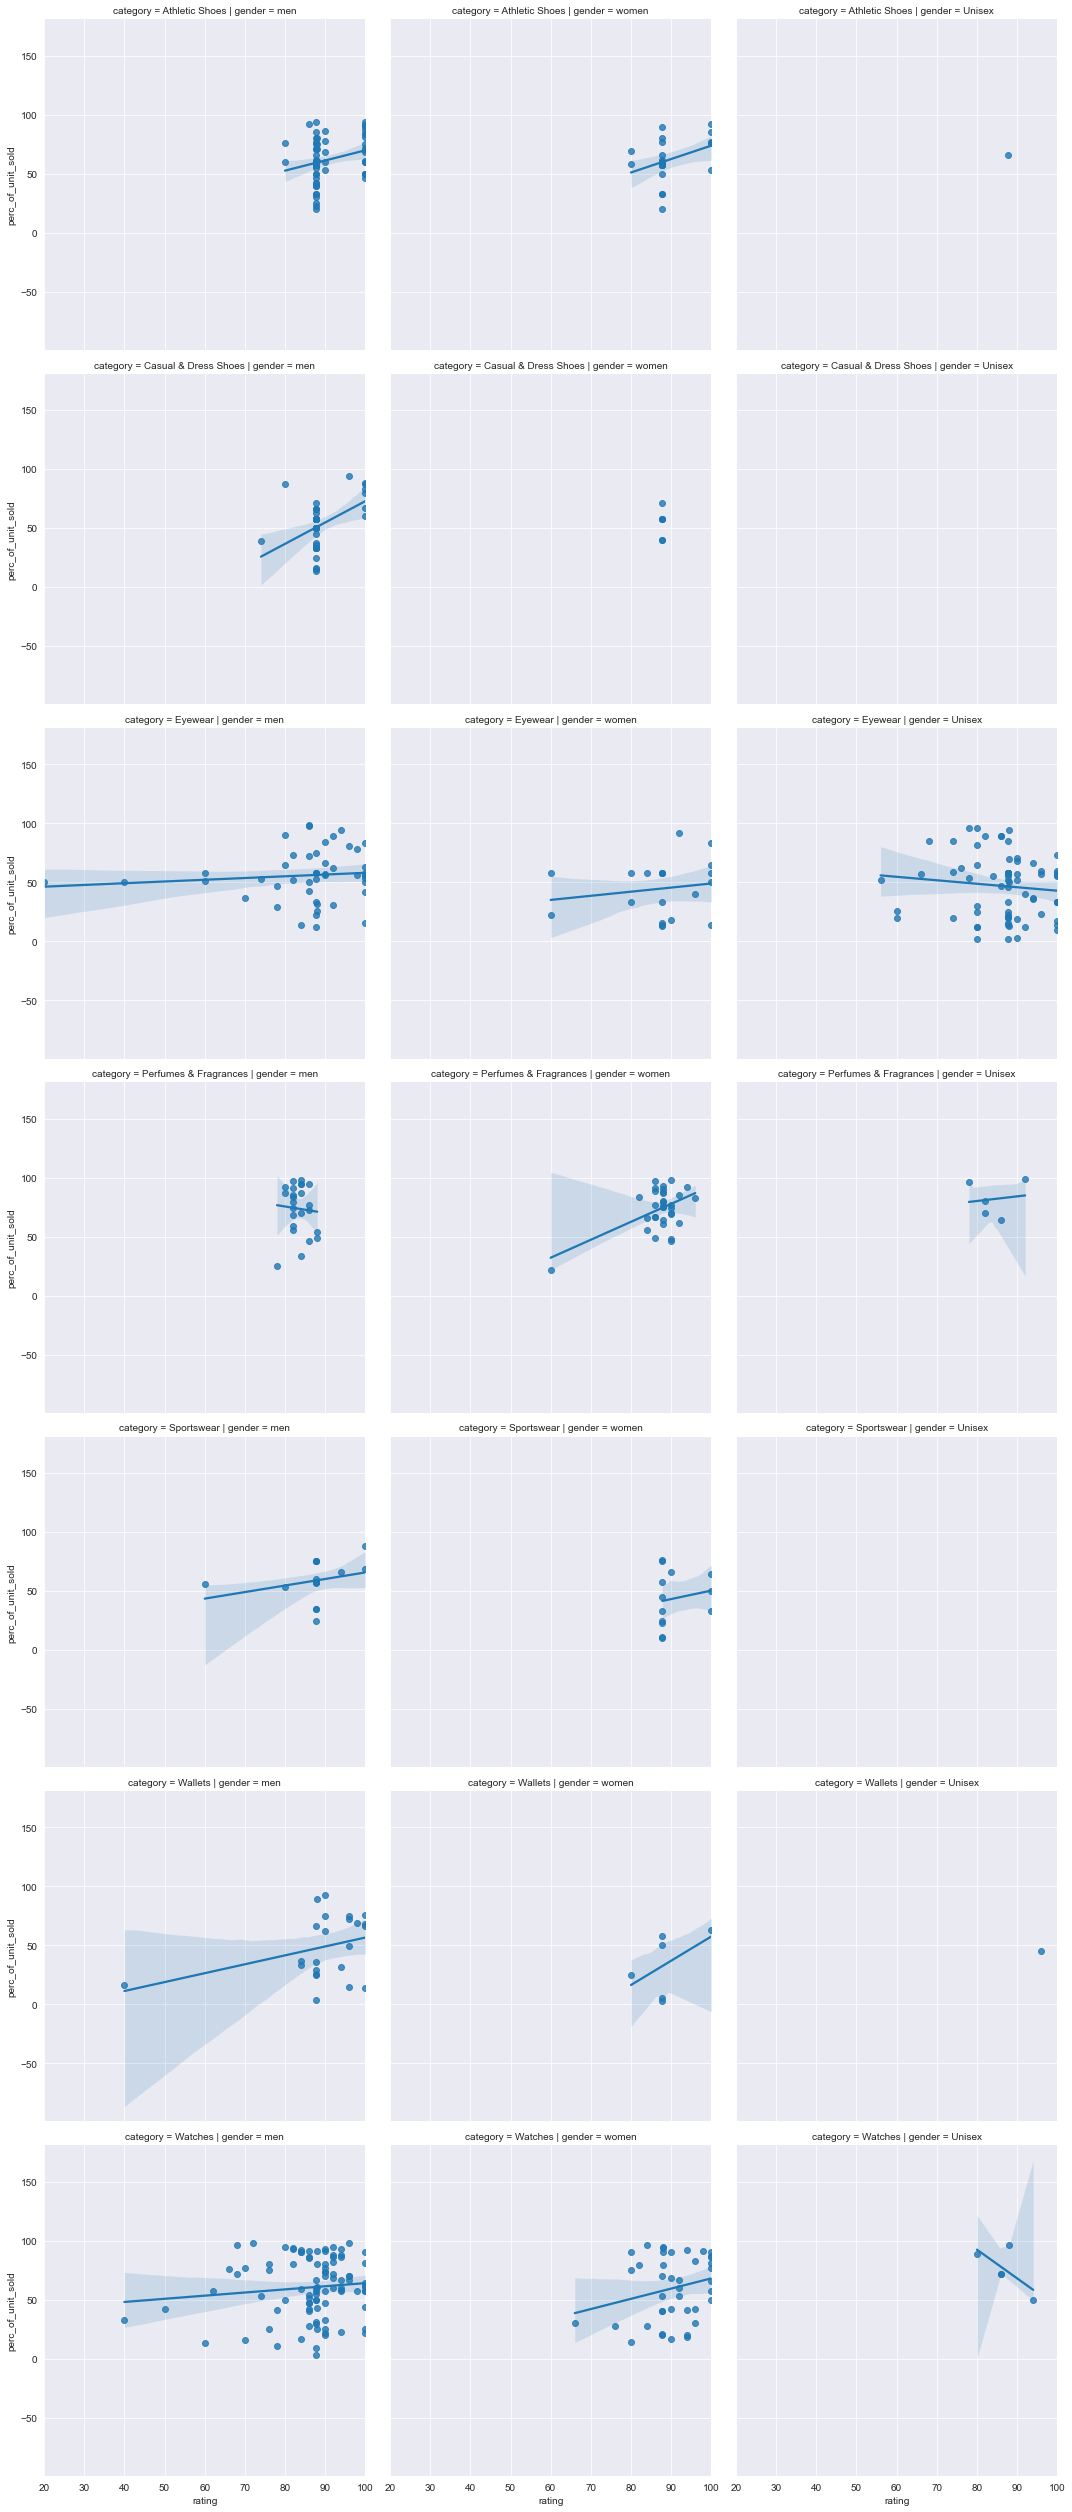

In [159]:
plt.figure(figsize=(10, 8))
sns.lmplot(x='rating', y='perc_of_unit_sold', col='gender', row='category', data=df)
plt.tight_layout()
# plt.savefig('5_.png')
plt.show()

- Untuk gender Pria:
    - Athletic Shoes: semakin besar unit yang dibeli semakin besar ratingnya
    - Casual & Dress Shoes: semakin besar unit yang dibeli semakin besar ratingnya
    - Eyewear: semakin besar unit yang dibeli semakin besar ratingnya tapi tidak signifikan
    - Perfumes & Fragrances: semakin besar unit yang dibeli semakin kecil ratingnya
    - Sportswear: semakin besar unit yang dibeli semakin besar ratingnya
    - Wallets: semakin besar unit yang dibeli semakin besar ratingnya
    - Watches: semakin besar unit yang dibeli semakin besar ratingnya
        
- Untuk gender Wanita:
    - Athletic Shoes: semakin besar unit yang dibeli semakin besar ratingnya
    - Casual & Dress Shoes: Tidak signifikan
    - Eyewear: semakin besar unit yang dibeli semakin besar ratingnya tapi tidak signifikan
    - Perfumes & Fragrances: semakin besar unit yang dibeli semakin besar ratingnya
    - Sportswear: semakin besar unit yang dibeli semakin besar ratingnya
    - Wallets: semakin besar unit yang dibeli semakin besar ratingnya
    - Watches: semakin besar unit yang dibeli semakin besar ratingnya
- Untuk Produk Unisex:
    - Eyewear: semakin besar unit yang dibeli semakin kecil ratingnya
    - Watches: semakin besar unit yang dibeli semakin kecil ratingnya

## Analisis Shipping Rate

In [175]:
df.groupby(['category', 'shpping_rate']).agg({'Loss':'mean', 'rating': 'mean', 'perc_of_unit_sold': 'mean'})

Loss     rating  \
category              shpping_rate                                          
Athletic Shoes        Eligible for FREE Shipping   6753.484963  90.611408   
                      FREE Shipping                8942.604152  91.149270   
Casual & Dress Shoes  Eligible for FREE Shipping   6113.061130  85.570648   
                      FREE Shipping                9425.952447  89.592163   
Eyewear               Eligible for FREE Shipping   9433.465806  84.349928   
                      FREE Shipping               23834.904920  87.180027   
Perfumes & Fragrances Eligible for FREE Shipping  13930.160000  85.233333   
                      FREE Shipping                5774.335000  95.000000   
Sportswear            Eligible for FREE Shipping   4746.109152  88.971009   
                      FREE Shipping                6201.555862  87.807963   
Wallets               Eligible for FREE Shipping   4880.176130  89.935988   
                      FREE Shipping               11522.253333  89.269321   
Watches               Eligible for FREE Shipping  30680.117647  84.705882   
                      FREE Shipping               86445.674347  88.121361   

                                                  perc_of_unit_sold  
category              shpping_rate                                   
Athletic Shoes        Eligible for FREE Shipping          61.559934  
                      FREE Shipping                       62.894430  
Casual & Dress Shoes  Eligible for FREE Shipping          67.779693  
                      FREE Shipping                       51.377068  
Eyewear               Eligible for FREE Shipping          54.387097  
                      FREE Shipping                       48.372140  
Perfumes & Fragrances Eligible for FREE Shipping          74.016667  
                      FREE Shipping                       87.500000  
Sportswear            Eligible for FREE Shipping          52.093539  
                      FREE Shipping                       57.678161  
Wallets               Eligible for FREE Shipping          44.765858  
                      FREE Shipping                       55.666667  
Watches               Eligible for FREE Shipping          77.058824  
                      FREE Shipping                       58.529016

## Kesimpulan dan Saran

- Unit yang terjual setelah pemotongan harga diharapkan dapat meningkatkan persentase pembelian
- Tiga kategori yang paling banyak menghasilkan Loss setelah pemotongan harga adalah Watches, Eyewear dan Perfumes & Fragrances.
- Dalam hal persentase unit terjual, kategori Eyewear tidak sebanding/lebih rendah daripada kategori Watches dan Perfumes & Fragrances. Hal ini, menunjukkan bahwa walau telah turun harga, konsumen tidak terlalu tertarik dengan pembelian eyewear.
- Dalam hal rating, pada kategori Perfumes & Fragrances, semakin banyak unit terjual, rating yang diberikan semakin kecil. Ada kemungkinan konsumen tidak terlalu puas dengan produk yang telah dibeli.

### Produk-produk Rekomendasi yang harus diperhatikan

In [189]:
df_watches = df[(df['category'] == 'Watches')]
# Jbw, Burgi, Akribos, Burberry dan August
df_watches = df_watches[(df_watches['Brand'] == 'Jbw') | (df_watches['Brand'] == 'Burgi') | (df_watches['Brand'] == 'Akribos') | (df_watches['Brand'] == 'Burberry') | (df_watches['Brand'] == 'August')]
print('Produk-produk "Watches":')
for idx, i in enumerate(df_watches['product'].values, start=1):
    print(f'{idx}. {i}')

Produk-produk "Watches":
1. JBW Mondrian Women's 16 Diamonds Rose Gold Dial Stainless Steel Band Watch - J6303C
2. Burberry BU9509 For Women (Analog, Casual Watch), Leather
3. Burberry Watch For Men,Stainless Steel Band, Quartz, BU9351, Analog
4. Akribos XXIV Men's Silver Dial Stainless Steel Band Watch - AK813SS, Analog, Swiss Quartz
5. Burberry BU9015
 Womens Analog Leather Watch
6. Akribos XXIV Men's Black Dial Metal Band Watch - AK814TTB, Analog, Japanese Quartz
7. JBW Skye 0.05 ctw Diamond Women's White MOP Dial Genuine Leather Band Watch - J6378C
8. Burberry Watch for Women , Quartz , Leather , BU9132, Analog
9. August Steiner Men's Gold-Tone And Blue Dial Leather Band Watch - AS8183SSB, Analog, Japanese Quartz Movement
10. August Steiner Women's Silver Dial Stainless Steel Band Watch - AS8228SS
11. Burberry BU9006 For Men Analog, Casual Watch
12. Akribos XXIV Men's Black Dial Leather Band Watch - AK911BK, Analog, Quartz Movement
13. JBW Alessandra for Women - Analog Stainless St

In [190]:
df_watches

,category,product,Original_price,price,perc_of_unit_sold,rating,shpping_rate,gender,Orig_minus_price,Orig_mltply_unit_sold,Price_mltply_unit_sold,Loss,Brand
431,Watches,JBW Mondrian Women's 16 Diamonds Rose Gold Dia...,2990.0,564.98,94.0,88.000000,FREE Shipping,women,2425.02,281060.0,53108.12,227951.88,Jbw
433,Watches,"Burberry BU9509 For Women (Analog, Casual Watc...",2040.0,1088.48,68.0,90.000000,FREE Shipping,women,951.52,138720.0,74016.64,64703.36,Burberry
450,Watches,"Burberry Watch For Men,Stainless Steel Band, Q...",2865.0,1196.49,91.0,90.000000,FREE Shipping,men,1668.51,260715.0,108880.59,151834.41,Burberry
455,Watches,Akribos XXIV Men's Silver Dial Stainless Steel...,2610.0,209.49,81.0,100.000000,FREE Shipping,men,2400.51,211410.0,16968.69,194441.31,Akribos
456,Watches,Burberry BU9015\n Womens Analog Leather Watch,2040.0,798.48,91.0,98.000000,FREE Shipping,women,1241.52,185640.0,72661.68,112978.32,Burberry
457,Watches,Akribos XXIV Men's Black Dial Metal Band Watch...,1860.0,228.99,57.0,62.000000,FREE Shipping,men,1631.01,106020.0,13052.43,92967.57,Akribos
458,Watches,JBW Skye 0.05 ctw Diamond Women's White MOP Di...,1879.0,523.98,21.0,87.807963,FREE Shipping,women,1355.02,39459.0,11003.58,28455.42,Jbw
466,Watches,"Burberry Watch for Women , Quartz , Leather , ...",1625.0,696.49,86.0,100.000000,FREE Shipping,women,928.51,139750.0,59898.14,79851.86,Burberry
474,Watches,August Steiner Men's Gold-Tone And Blue Dial L...,1600.0,215.48,72.0,68.000000,FREE Shipping,men,1384.52,115200.0,15514.56,99685.44,August
477,Watches,August Steiner Women's Silver Dial Stainless S...,703.0,228.99,75.0,80.000000,FREE Shipping,women,474.01,52725.0,17174.25,35550.75,August


In [201]:
df_watches_product = df_watches.groupby(['product', 'shpping_rate']).agg({'Loss': 'mean', 'rating': 'mean', 'perc_of_unit_sold': 'mean'}).reset_index().sort_values(by='Loss', ascending=False)
df_watches_product['Loss%'] = df_watches_product['Loss']/df_watches_product['perc_of_unit_sold']
df_watches_product.sort_values(by='Loss%', ascending=False)

,product,shpping_rate,Loss,rating,perc_of_unit_sold,Loss%
32,JBW Jet Setter Men's 234 Diamonds Gold Dial Go...,FREE Shipping,2729741.98,72.000000,98.0,27854.51
41,JBW Victory Women's 16 Diamonds Mother of Pear...,FREE Shipping,404165.58,82.000000,79.0,5116.02
42,JBW Victory Women's 16 Diamonds Mother of Pear...,FREE Shipping,457189.40,88.000000,95.0,4812.52
27,JBW Alessandra for Women - Analog Stainless St...,FREE Shipping,196861.91,94.000000,41.0,4801.51
44,"JBW Watch For men With 16 Diamonds, JB-8102-B",FREE Shipping,404859.88,82.000000,94.0,4307.02
39,JBW Victor Men's 16 Diamonds Black Dial Black ...,FREE Shipping,280201.50,76.000000,75.0,3736.02
35,JBW Men's G3 World Traveler Set 0.16 ctw Diamo...,FREE Shipping,101780.28,86.000000,28.0,3635.01
33,"JBW Laurel Watch for Women , Stainless Steel ,...",FREE Shipping,324810.90,90.000000,90.0,3609.01
38,"JBW The G4 Calfskin Leather Band Men's Watch, ...",FREE Shipping,38874.22,78.000000,11.0,3534.02
34,"JBW Laurel Watch for Women , Stainless Steel ,...",FREE Shipping,180359.53,92.000000,53.0,3403.01


- Ketgori produk Watches merupakan produk yang memiliki persentase unit terjual yang besar setelah harganya diturunkan dan juga memiliki Loss yang paling besar dibanding kategori lain
- Hal ini berarti Watches merupakan kategori yang diminati banyak konsumen setelah harga diturunkan
- Oleh karena itu, penurunan harga pada produk-produk ini diharapkan tidak terlalu besar guna mengurangi kerugian perusahaan
- Untuk Watches, konsumen lebih banyak untuk tidak shipping dalam pembeliannya. Namun, konsumen yang shipping memberikan rating yang lebih tinggi dibanding yang tidak shipping. Oleh karena itu, dapat disimpulkan bahwa kualitas logistik pengiriman barang untuk Watches sangatlah bagus.

In [195]:
df_eyewear = df[(df['category'] == 'Eyewear')]
# Miu, Salvatore, Bottega, Fendi dan G-Star.
df_eyewear = df_eyewear[(df_eyewear['Brand'] == 'Miu') | (df_eyewear['Brand'] == 'Salvatore') | (df_eyewear['Brand'] == 'Bottega') | (df_eyewear['Brand'] == 'Fendi') | (df_eyewear['Brand'] == 'G-Star')]
print('Produk-produk Eyewear:')
for idx, i in enumerate(df_eyewear['product'].values, start=1):
    print(f'{idx}. {i}')


Produk-produk Eyewear:
1. Miu Miu Rimless Women's Sunglasses - 56Ts-Xej1A1 - 63 mm, Black Lens
2. Salvatore Ferragamo Women's Sunglasses - Sf879S-213 53, 150 mm, Black Lens, Square Frame
3. Fendi Sunglasses For Women, Alloy, Pink, Ff 0177/S 0J, Cat Eye Frame
4. Bottega Veneta Sunglasses For Unisex, Bv0013S-001-59, Brown Lens, Round Frame


In [193]:
df_eyewear_product = df_eyewear.groupby('product').agg({'Loss': 'mean', 'rating': 'mean', 'perc_of_unit_sold': 'mean'}).reset_index().sort_values(by='Loss', ascending=False)
df_eyewear_product['Loss%'] = df_eyewear_product['Loss']/df_eyewear_product['perc_of_unit_sold']
df_eyewear_product.sort_values(by='Loss%', ascending=False)

,product,Loss,rating,perc_of_unit_sold,Loss%
2,Miu Miu Rimless Women's Sunglasses - 56Ts-Xej1...,51151.000000,100.000000,50.000000,1023.02
3,Salvatore Ferragamo Women's Sunglasses - Sf879...,58342.036552,87.807963,57.678161,1011.51
0,"Bottega Veneta Sunglasses For Unisex, Bv0013S-...",12852.140000,87.807963,14.000000,918.01
1,"Fendi Sunglasses For Women, Alloy, Pink, Ff 01...",31060.400000,96.000000,40.000000,776.51


- Ketgori produk Eyewear merupakan produk yang memiliki persentase unit terjual tidak lebih banyak dari semua kategori yang merupakan 3 kategori dengan Loss terbesar
- Kategori produk Eyewear juga memiliki Loss yang besar dibanding kategori lain. Namun tidak sebanding dengan unit terjualnya.
- Hal ini menunjukan bahwa kategori Eyewear bukan merupakan kategori yang diminati dibanding kategori Watches, Perfumes & Fragrances dan juga Athletic Shoes, jika harganya diturunkan.
- Oleh karena itu, hal yang perlu diperhatikan pada produk ini antara lain kualitas produk/perancangan produk kembali dan juga marketing produk agar konsumen tertarik dengan kategori ini setelah dilakukan pemotongan harga
- Konsumen yang melakukan shipping memberikan rating yang rendah pada kategori ini. Ini semakin menguatkan bahwa kualitas produk ataupun pengiriman produk haruslah ditingkatkan dan dilakukan analisis kembali oleh tim yang terkait.

In [197]:
df_perfumes_product = df[(df['category'] == 'Perfumes & Fragrances')]
#  Fatale, Roberto, Fendi, Tommy, Elizabeth dan Britz.
df_perfumes_product = df_perfumes_product[(df_perfumes_product['Brand'] == 'Fatale') | (df_perfumes_product['Brand'] == 'Roberto') | (df_perfumes_product['Brand'] == 'Tommy') | (df_perfumes_product['Brand'] == 'Fendi') | (df_perfumes_product['Brand'] == 'Elizabeth') | (df_perfumes_product['Brand'] == 'Brit')]
print('Produk-produk Perfumes & Fragrances')
for idx, i in enumerate(df_perfumes_product['product'].values, start=1):
    print(f'{idx}. {i}')


Produk-produk Perfumes & Fragrances
1. Roberto Cavalli For Women - Eau de Parfum, 75ml
2. Roberto Cavalli Nero Assoluto for Women - Eau de Parfum, 75ml
3. Elizabeth Arden 5th Avenue for Women - Eau de Parfum, 125ml
4. Fendi Furiosa for Women - Eau de Parfum, 50ml
5. Brit Rhythm by Burberry for Men - Eau de Toilette, 50ml
6. Roberto Cavalli Paradiso for Women - Eau de Parfum, 50ml
7. Tommy Girl By Tommy Hilfiger For Women - Eau De Toilette, 100 ml
8. Fatale by Agent Provocateur for Women - Eau de Parfum, 50ml


In [199]:
df_perfumes = df_perfumes_product.groupby('product').agg({'Loss': 'mean', 'rating': 'mean', 'perc_of_unit_sold': 'mean'}).reset_index().sort_values(by='Loss', ascending=False)
df_perfumes['Loss%'] = df_perfumes['Loss']/df_perfumes['perc_of_unit_sold']
df_perfumes.sort_values(by='Loss%', ascending=False)

,product,Loss,rating,perc_of_unit_sold,Loss%
2,Fatale by Agent Provocateur for Women - Eau de...,9447.02,60.0,22.0,429.41
4,"Roberto Cavalli For Women - Eau de Parfum, 75ml",31483.50,88.0,75.0,419.78
6,Roberto Cavalli Paradiso for Women - Eau de Pa...,35200.20,92.0,85.0,414.12
3,"Fendi Furiosa for Women - Eau de Parfum, 50ml",29833.17,88.0,87.0,342.91
7,Tommy Girl By Tommy Hilfiger For Women - Eau D...,26057.68,88.0,88.0,296.11
1,Elizabeth Arden 5th Avenue for Women - Eau de ...,26573.40,88.0,90.0,295.26
0,Brit Rhythm by Burberry for Men - Eau de Toile...,10013.34,84.0,34.0,294.51
5,Roberto Cavalli Nero Assoluto for Women - Eau ...,5224.87,86.0,49.0,106.63


- Ketgori produk Perfumes & Fragrances merupakan produk yang memiliki persentase unit terjual paling besar setelah harganya diturunkan dan juga memiliki Loss yang besar dibanding kategori lain. 
- Kategori ini memiliki Loss yang tidak terlalu besar, namun unit terjualnya sangatlah tinggi. Oleh karena itu, dapat diasumsikan penurunan harga yang tidak banyak pada kategori ini dapat membuat konsumen tertarik untuk membelinya.
- Hal ini berarti Perfumes & Fragrances merupakan kategori yang diminati banyak konsumen setelah harga diturunkan.
- Penjualan pada kategori ini sangat bermanfaat apabila perusahaan akan mengadakan cuci gudang. Produk yang telah lama tidak terjual, yang mengakibatkan tempat penyimpanannya penuh, akan dapat dijual bila harganya diturunkan.
- Pada kategori ini, konsumen lebih banyak shipping dalam pembeliannya. Konsumen yang melakukan shipping pun memberikan rating yang sangat tinggi. Hal ini menandakan, konsumen puas terhadap produk ataupun logistik pengirimannya.